# Text Classification: Identifying Articles as About a Person or Not

In [373]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk

from bs4 import BeautifulSoup as bs
import requests
import time
import random

import re

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

In [ ]:
#nltk.download('wordnet')

In [68]:
def collect_all_links():
    links = get_links('Benjamin Franklin')
    time.sleep(1)
    links2 = get_links('United States Declaration of Independence')
    links3 = get_links('Martin Luther King Jr.')
    time.sleep(1)
    links4 = get_links('John Adams (miniseries)')
    time.sleep(.5)
    links5 = get_links('Louisa May Alcott')

    links.extend(links2)
    links.extend(links3)
    links.extend(links4)
    links.extend(links5)
    
    all_links = list(set(links))
    
    for i, v in enumerate(set(links)):
        try:
            links_temp = get_links(v.get('title'))
            all_links.extend(links_temp)
            time.sleep(random.choice([.25,.75,1,.5,.5,1,1.5,2]))
            print('\rFinished: {0}/{1}{2}'.format(i+1, len(set(links)), ' '*100) , end="\r")

        except:
            print('\rERROR: {0}{1}'.format(v.get('title'), ' '*100), end="\r")
            continue
    return all_links

def collect_text(all_links):
    
    splits = split_into_20_names(all_links)
    
    df_all = get_text(splits[0])
    
    for i, v in enumerate(splits[1:]):
        df = get_text(v)
        df_all = df_all.append(df)
        time.sleep(random.choice([.25,.75,1,.5,.5]))
        print('\rFinished: {0}/{1}{2}'.format(i+1, len(splits), ' '*100), end="\r")

    return df_all

In [19]:
def split_into_20_names(links):
    
    links_new = list(set(links))
    
    all_links_lists = []
    
    
    links = []
    for i in links_new:
        if i.get('title') is not None:
            links.append(i)
    
    for i, v in enumerate(links):
        if i == 0:
            list1 = []
            list1.append(v.get('title'))
        elif i % 20 == 0:
            all_links_lists.append(list1)
            list1 = []
            list1.append(v.get('title'))
        elif (i + 1) == len(links):
            list1.append(v.get('title'))
            all_links_lists.append(list1)
        else:
            list1.append(v.get('title'))
            
    return all_links_lists

In [4]:
def get_links(name):

    api_call = "http://en.wikipedia.org/w/api.php?action=parse&format=json&page="

    page = requests.get(api_call + name)
    source = bs(page.json()['parse']['text']['*'], 'html.parser')

    # Get all paragraph text
    p = source.find_all('p')

    links_p = []
    for para in p:
        p_source = bs(str(para), 'html.parser')
        lis = p_source.find_all('a', href = True)
        for lin in lis:
            links_p.append(lin)
    return links_p

In [64]:
def get_text(names_20):
    
    titles = '|'.join(names_20)
    
    response = requests.get(
         'https://en.wikipedia.org/w/api.php',
        params={
             'action': 'query',
             'format': 'json',
             'titles': titles,
             'prop': 'extracts',
             'exintro': True,
             'explaintext': True,
         }
    ).json()
    
    try:
        pages = response['query']['pages']

        page_ids = list(pages.keys())

        texts = [pages[x]['extract'] for x in page_ids]
        names_all = [pages[x]['title'] for x in page_ids]
    
        df = pd.DataFrame({'Titles':names_all, 'Text':texts})
        df = df.replace('', np.nan).dropna()
    except:
        df = pd.DataFrame()
    return df

In [30]:
%%time

all_links = collect_all_links()

Wall time: 32min 31s                                                                                                                                                                                                            


In [31]:
len(all_links)

251865

In [69]:
%%time

df_all = collect_text(all_links)

Wall time: 1h 11min 12s                                                                                                


In [76]:
df_to_save = df_all.reset_index()
df_to_save = df_to_save.drop(columns = 'index')

In [77]:
df_to_save.to_csv('wiki_desc_dataset.csv')

In [346]:
df_labled = pd.read_csv('wiki_desc_dataset_labels.csv')
df_labled_only = (df_labled.dropna()
                            .drop(columns= 'Unnamed: 0'))
df_labled_only.head()


,LABEL,Titles,Text
0,PERSON,Charles H. Percy,"Charles Harting Percy (September 27, 1919 – Se..."
1,CONCEPT,Head of state,A head of state (or chief of state) is the pub...
2,PERSON,Henry Winkler,"Henry Franklin Winkler (born October 30, 1945)..."
3,EVENT,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...
4,MISC,London Buses route 176,London Buses route 176 is a Transport for Lond...


In [347]:
df_labled_only['LABEL'] = df_labled_only['LABEL'].apply(lambda x: 1 if x == 'PERSON' else 0)
df_labled_only.head()

,LABEL,Titles,Text
0,1,Charles H. Percy,"Charles Harting Percy (September 27, 1919 – Se..."
1,0,Head of state,A head of state (or chief of state) is the pub...
2,1,Henry Winkler,"Henry Franklin Winkler (born October 30, 1945)..."
3,0,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...
4,0,London Buses route 176,London Buses route 176 is a Transport for Lond...


In [402]:
X_train, X_test, y_train, y_test = train_test_split(df_labled_only['Text'], 
                                                    df_labled_only['LABEL'], 
                                                    random_state=1, train_size= .9)

X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(X_train, y_train, random_state = 0, train_size = .8)
len(X_train_mini), len(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2698, 3373)

In [274]:
tfidf = TfidfVectorizer(lowercase=False, min_df = 3).fit(X_train_mini)
count = CountVectorizer(lowercase=False, min_df = 3).fit(X_train_mini)
len(tfidf.get_feature_names()), len(count.get_feature_names())

(11906, 11906)

In [275]:
X_train_tf = tfidf.transform(X_train_mini)
X_test_tf = tfidf.transform(X_test_mini)

X_train_c = count.transform(X_train_mini)
X_test_c = count.transform(X_test_mini)

NB_tf = MultinomialNB().fit(X_train_tf, y_train_mini)
NB_c = MultinomialNB().fit(X_train_c, y_train_mini)


y_train_pred_tf = NB_tf.predict(X_train_tf)
y_test_pred_tf = NB_tf.predict(X_test_tf)

y_train_pred_c = NB_c.predict(X_train_c)
y_test_pred_c = NB_c.predict(X_test_c)

print('TFIDF: \nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_train_mini, y_train_pred_tf), roc_auc_score(y_train_mini, y_train_pred_tf)))
print('COUNT:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_train_mini, y_train_pred_c), roc_auc_score(y_train_mini, y_train_pred_c)))

print('TFIDF TEST: \nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_test_mini, y_test_pred_tf), roc_auc_score(y_test_mini, y_test_pred_tf)))
print('COUNT TEST:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_test_mini, y_test_pred_c), roc_auc_score(y_test_mini, y_test_pred_c)))

TFIDF: 
Accuracy: 0.9629355077835434
ROC AUC: 0.945745308962778

COUNT:
Accuracy: 0.9562638991845812
ROC AUC: 0.9650853590383967

TFIDF TEST: 
Accuracy: 0.9259259259259259
ROC AUC: 0.8910255104119973

COUNT TEST:
Accuracy: 0.9333333333333333
ROC AUC: 0.9424538489751006



Seems like the CountVectorizer does better for this application. This espeically makes sense for words such as 'he/she' which would occur quite frequently in the corpus but would also appear quite frequently in the texts we care about. So if we use tfidf, then we weight these as unimportant, but for our application this is pretty important.

# Exploring how min_df affects the later model

In [261]:
train_accuracy = []
train_roc_auc = []
test_accuracy = []
test_roc_auc = []

for n in range(50):

    count = CountVectorizer(lowercase=False, min_df = n).fit(X_train_mini)

    X_train_c = count.transform(X_train_mini)
    X_test_c = count.transform(X_test_mini)

    NB_c = MultinomialNB().fit(X_train_c, y_train_mini)

    y_train_pred_c = NB_c.predict(X_train_c)
    y_test_pred_c = NB_c.predict(X_test_c)
    train_accuracy.append(accuracy_score(y_train_mini, y_train_pred_c))
    train_roc_auc.append(roc_auc_score(y_train_mini, y_train_pred_c))
    test_accuracy.append(accuracy_score(y_test_mini, y_test_pred_c))
    test_roc_auc.append(roc_auc_score(y_test_mini, y_test_pred_c))    
    
    

<IPython.core.display.Javascript object>


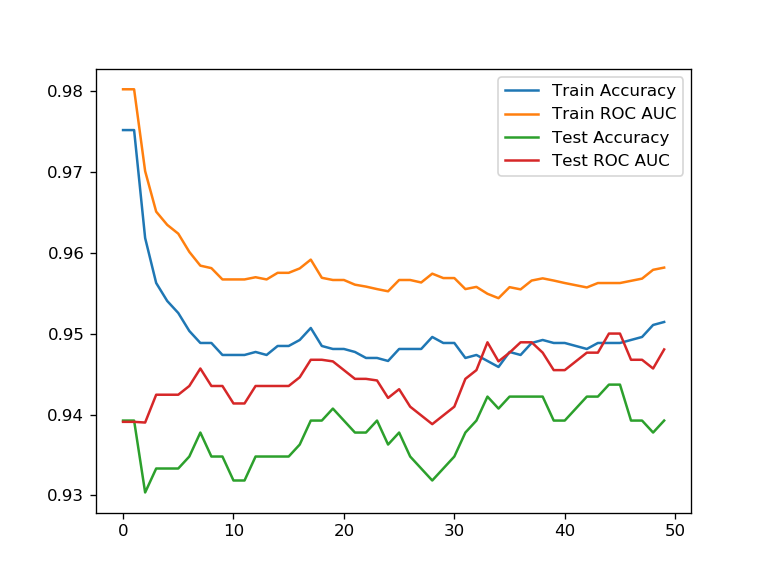

In [262]:
%matplotlib notebook
plt.figure()
plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(train_roc_auc, label = 'Train ROC AUC')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.plot(test_roc_auc, label = 'Test ROC AUC')
plt.legend()

In [200]:
list_of_people = [3027, 3032, 3033, 3038, 3976, 3990, 3991, 3992, 3501, 3507]

In [321]:
''.join(re.findall(r'([\D])', df_labled.iloc[3033]['Text']))

"Kenneth Allen Schmied (July ,  – April , ), a Republican, served as Mayor of Louisville, Kentucky.\r\nSchmied was the son of a Swiss immigrant who sold coffee door to door and later owned a furniture store.  Kenneth A. Schmied and a brother entered the family furniture business.\r\nSchmied was not politically active until  when a local party leader asked him to help organize a rally for Republican presidential candidate Richard M. Nixon.  The local party was impressed with his ability and recruited him to run for the Board of Aldermen in Louisville's Third Ward.  Schmied directed the local Republican effort that fall and the Republicans swept the local elections.  Republican William O. Cowger was elected Mayor of Louisville and Schmied won the aldermanic seat and was elected President of the Board of Aldermen.\r\nCowger chose Schmied as his successor as mayor.  Schmied ran for the office in .  He defeated a former sheriff in the Republican primary and won the general election against 

In [267]:
count2 = CountVectorizer(lowercase=False, min_df = 20).fit(X_train_mini)
X_train_c = count2.transform(X_train_mini)
NB_c = MultinomialNB().fit(X_train_c, y_train_mini)

all_samples = []

for i in list_of_people:
    y_sample = NB_c.predict(count2.transform([df_labled['Text'][i]]))
    all_samples.append(y_sample[0])
print('Results:', all_samples)
print('Accuracy =', sum(all_samples)/len(all_samples))

Results: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy = 0.9


In [284]:
CountVectorizer?

# Log Reg, SVM, & Multinomial Bayes

In [279]:
count2 = CountVectorizer(lowercase=False, min_df = 20).fit(X_train_mini)

X_train_c = count2.transform(X_train_mini)
X_test_c = count2.transform(X_test_mini)

NB = MultinomialNB().fit(X_train_c, y_train_mini)
log_reg = LogisticRegression().fit(X_train_c, y_train_mini)
svc = SVC().fit(X_train_c, y_train_mini)

y_train_pred_nb = NB.predict(X_train_c)
y_test_pred_nb = NB.predict(X_test_c)

y_train_pred_lr = log_reg.predict(X_train_c)
y_test_pred_lr = log_reg.predict(X_test_c)

y_train_pred_sv = svc.predict(X_train_c)
y_test_pred_sv = svc.predict(X_test_c)

print('TRAIN')
print('NB:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini, y_train_pred_nb), roc_auc_score(y_train_mini, y_train_pred_nb)))
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini, y_train_pred_lr), roc_auc_score(y_train_mini, y_train_pred_lr)))
print('SVC:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_train_mini, y_train_pred_sv), roc_auc_score(y_train_mini, y_train_pred_sv)))

print('TEST')
print('NB:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini, y_test_pred_nb), roc_auc_score(y_test_mini, y_test_pred_nb)))
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini, y_test_pred_lr), roc_auc_score(y_test_mini, y_test_pred_lr)))
print('SVC:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_test_mini, y_test_pred_sv), roc_auc_score(y_test_mini, y_test_pred_sv)))

TRAIN
NB:
Accuracy: 0.9481097108969607
ROC AUC: 0.9566356509356816
Log Reg:
Accuracy: 0.9996293550778355
ROC AUC: 0.9997275204359672
SVC:
Accuracy: 0.9688658265381764
ROC AUC: 0.9599256127632837

TEST
NB:
Accuracy: 0.9392592592592592
ROC AUC: 0.9454949264436203
Log Reg:
Accuracy: 0.9644444444444444
ROC AUC: 0.9587391499246097
SVC:
Accuracy: 0.9540740740740741
ROC AUC: 0.9409511390032194



In [288]:
count2 = CountVectorizer(lowercase=False, min_df = 20, ngram_range=(1,3)).fit(X_train_mini)

X_train_c = count2.transform(X_train_mini)
X_test_c = count2.transform(X_test_mini)

NB = MultinomialNB().fit(X_train_c, y_train_mini)
log_reg = LogisticRegression().fit(X_train_c, y_train_mini)
svc = SVC().fit(X_train_c, y_train_mini)

y_train_pred_nb = NB.predict(X_train_c)
y_test_pred_nb = NB.predict(X_test_c)

y_train_pred_lr = log_reg.predict(X_train_c)
y_test_pred_lr = log_reg.predict(X_test_c)

y_train_pred_sv = svc.predict(X_train_c)
y_test_pred_sv = svc.predict(X_test_c)

print('TRAIN')
print('NB:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini, y_train_pred_nb), roc_auc_score(y_train_mini, y_train_pred_nb)))
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini, y_train_pred_lr), roc_auc_score(y_train_mini, y_train_pred_lr)))
print('SVC:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_train_mini, y_train_pred_sv), roc_auc_score(y_train_mini, y_train_pred_sv)))

print('TEST')
print('NB:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini, y_test_pred_nb), roc_auc_score(y_test_mini, y_test_pred_nb)))
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini, y_test_pred_lr), roc_auc_score(y_test_mini, y_test_pred_lr)))
print('SVC:\nAccuracy: {0}\nROC AUC: {1}\n'.format(accuracy_score(y_test_mini, y_test_pred_sv), roc_auc_score(y_test_mini, y_test_pred_sv)))

TRAIN
NB:
Accuracy: 0.9566345441067458
ROC AUC: 0.963209575620183
Log Reg:
Accuracy: 0.9996293550778355
ROC AUC: 0.9997275204359672
SVC:
Accuracy: 0.9588584136397331
ROC AUC: 0.9418273496231699

TEST
NB:
Accuracy: 0.9511111111111111
ROC AUC: 0.9566913892171646
Log Reg:
Accuracy: 0.9733333333333334
ROC AUC: 0.9677757854843311
SVC:
Accuracy: 0.9422222222222222
ROC AUC: 0.9169689066384124



In [298]:
param_grid_lr = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C':[.01,1,10]}

log_gridsearch = GridSearchCV(LogisticRegression(), param_grid_lr, cv=10, scoring='roc_auc', n_jobs = -1)
log_gridsearch.fit(X_train_c, y_train_mini)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.01, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [301]:
log_best = log_gridsearch.best_estimator_

In [400]:
y_train_pred_lr = log_best.predict(X_train_c)
y_test_pred_lr = log_best.predict(X_test_c)

print('TRAIN')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini, y_train_pred_lr), roc_auc_score(y_train_mini, y_train_pred_lr)))
print('TEST')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini, y_test_pred_lr), roc_auc_score(y_test_mini, y_test_pred_lr)))


TRAIN
Log Reg:
Accuracy: 0.9996293550778355
ROC AUC: 0.9997275204359672
TEST
Log Reg:
Accuracy: 0.9733333333333334
ROC AUC: 0.9677757854843311


In [399]:
log_best.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [401]:
all_samples = []


for i in list_of_people:
    y_sample = log_best.predict(count2.transform([df_labled['Text'][i]]))
    all_samples.append(y_sample[0])
print('Results:', all_samples)
print('Accuracy =', sum(all_samples)/len(all_samples))

Results: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Accuracy = 0.9


In [367]:
def parse_rows(row):
    row['Numbers'] = len(re.findall(r'([\d]{4})', row['Text']))
    years = re.findall(r'([\d]{4})', row['Text'])
    years = [int(x) for x in years]
    if len(years) > 0:
        age = max(years) - min(years)
        if age > 100:
            age = 0
        row['Age'] = age
    elif len(years) == 0:
        row['Age'] = 0
    row['Text'] = ''.join(re.findall(r'([\D])', row['Text']))
    row['Title len'] = len(row['Titles'].split(' '))
    if len(re.findall(r'([(])',row['Text'])) > 0:
        row['( Flag'] = 1
    else:
        row['( Flag'] = 0
        
    if len(re.findall(r'(January|February|March|April|May|June|July|August|September|October|November|December)', row['Text'])) > 0:
        row['Month Flag'] = 1
    else:
        row['Month Flag'] = 0
    
    return row

In [360]:
df_labled_only.head()

,LABEL,Titles,Text
0,1,Charles H. Percy,"Charles Harting Percy (September 27, 1919 – Se..."
1,0,Head of state,A head of state (or chief of state) is the pub...
2,1,Henry Winkler,"Henry Franklin Winkler (born October 30, 1945)..."
3,0,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...
4,0,London Buses route 176,London Buses route 176 is a Transport for Lond...


In [368]:
df_parsed = df_labled_only.apply(parse_rows, axis = 1)
df_parsed.head()

,LABEL,Titles,Text,Numbers,Age,Title len,( Flag,Month Flag
0,1,Charles H. Percy,"Charles Harting Percy (September , – Septembe...",9,92,3,1,1
1,0,Head of state,A head of state (or chief of state) is the pub...,1,0,3,1,0
2,1,Henry Winkler,"Henry Franklin Winkler (born October , ) is an...",3,73,2,1,1
3,0,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...,5,12,2,1,1
4,0,London Buses route 176,London Buses route is a Transport for London ...,0,0,4,0,0


In [396]:
for i in ['Numbers','Age', 'Title len']:
    scaler = MinMaxScaler().fit(np.array(df_parsed[i]).reshape(-1, 1))
    df_parsed[i] = scaler.transform(np.array(df_parsed[i]).reshape(-1, 1))
    
df_parsed.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,LABEL,Titles,Text,Numbers,Age,Title len,( Flag,Month Flag
0,1,Charles H. Percy,"Charles Harting Percy (September , – Septembe...",0.209302,0.92,0.166667,1,1
1,0,Head of state,A head of state (or chief of state) is the pub...,0.023256,0.00,0.166667,1,0
2,1,Henry Winkler,"Henry Franklin Winkler (born October , ) is an...",0.069767,0.73,0.083333,1,1
3,0,La Violencia,La Violencia (Spanish pronunciation: [la βjoˈl...,0.116279,0.12,0.083333,1,1
4,0,London Buses route 176,London Buses route is a Transport for London ...,0.000000,0.00,0.250000,0,0


In [411]:
log_best.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [415]:
def new_matrix(count_matrix, df):
    final_matrix = sp.sparse.hstack((count_matrix, np.array([[x] for x in np.array(df['Numbers'])]), 
                                     np.array([[x] for x in np.array(df['Age'])]),
                                     np.array([[x] for x in np.array(df['Title len'])]),
                                      np.array([[x] for x in np.array(df['( Flag'])]),
                                      np.array([[x] for x in np.array(df['Month Flag'])]),
                                    ))
    return final_matrix

In [413]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_parsed.drop(columns = ['LABEL', 'Titles']), 
                                                    df_parsed['LABEL'], 
                                                    random_state=1, train_size= .9)

X_train_mini_p, X_test_mini_p, y_train_mini_p, y_test_mini_p = train_test_split(X_train_p, y_train_p,
                                                                                random_state = 0, train_size = .8)
print(len(X_train_mini), len(X_train))

count3 = CountVectorizer(lowercase=False, min_df = 20, ngram_range=(1,3)).fit(X_train_mini_p['Text'])

X_train_c_p = count3.transform(X_train_mini_p['Text'])
X_test_c_p = count3.transform(X_test_mini_p['Text'])

X_train_c_p = new_matrix(X_train_c_p, X_train_mini_p)
X_test_c_p = new_matrix(X_test_c_p, X_test_mini_p)

log_reg_p = LogisticRegression(solver = 'newton-cg').fit(X_train_c_p, y_train_mini_p)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2698 3373


In [416]:
y_train_pred_lr_p = log_reg_p.predict(X_train_c_p)
y_test_pred_lr_p = log_reg_p.predict(X_test_c_p)

print('TRAIN')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train_mini_p, y_train_pred_lr_p),
                                                     roc_auc_score(y_train_mini_p, y_train_pred_lr_p)))
print('TEST')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test_mini_p, y_test_pred_lr_p),
                                                     roc_auc_score(y_test_mini_p, y_test_pred_lr_p)))


TRAIN
Log Reg:
Accuracy: 0.9996293550778355
ROC AUC: 0.9997275204359672
TEST
Log Reg:
Accuracy: 0.9748148148148148
ROC AUC: 0.9675771221321162


## Eh. For all the work that goes into adding these new features, it really doesn't add anything. Marginal accuracy improvements with a decrease in ROC AUC = not worth it. Let's just stick with the bag of words approach.

# Final Model Testing

In [418]:
count_final = CountVectorizer(lowercase=False, min_df = 20, ngram_range=(1,3)).fit(X_train)

X_train_matrix = count_final.transform(X_train)
X_test_matrix = count_final.transform(X_test)

log_final = LogisticRegression(solver = 'newton-cg').fit(X_train_matrix, y_train)

In [419]:
y_train_finalpred = log_final.predict(X_train_matrix)
y_test_finalpred = log_final.predict(X_test_matrix)

print('TRAIN')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_train, y_train_finalpred),
                                                     roc_auc_score(y_train, y_train_finalpred)))
print('TEST')
print('Log Reg:\nAccuracy: {0}\nROC AUC: {1}'.format(accuracy_score(y_test, y_test_finalpred),
                                                     roc_auc_score(y_test, y_test_finalpred)))

TRAIN
Log Reg:
Accuracy: 0.9997035280166024
ROC AUC: 0.9997824194952133
TEST
Log Reg:
Accuracy: 0.9706666666666667
ROC AUC: 0.9641056664650131
